In [1]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

from math import log10, floor, pow, e, sqrt

from functions import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
'''Import Data Links'''
import_path = "./data/original-data/"

In [3]:
'''Colors'''
pal = sns.color_palette('GnBu', 5)
pal


[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

In [4]:
'''Functions'''
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

## Import and Setup

In [5]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv(import_path + 'VegData_LAI_Snow.csv')

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

In [6]:
'''Add Snow Year'''
#Snow year
allSnow_df['SYear'] = [2024 if allSnow_df.time[i] > pd.to_datetime('09-01-2023') else 2023 for i in range(0, len(allSnow_df.time))]

#Date of snow year
allSnow_df['SDOY'] = [(allSnow_df.time[i] - pd.to_datetime('09-01-2023')).days if allSnow_df.SYear[i] == 2024 else (allSnow_df.time[i] - pd.to_datetime('09-01-2022')).days for i in range(0, len(allSnow_df.time))]
allSnow_df.head()

,index,northing,easting,time,stakes,zones,aspect,slope,depths,watershed,SYear,SDOY
0,0,464644.0,5262240.0,2022-11-25,NaN,NaN,NaN,NaN,NaN,S6,2023,85
1,1,464644.0,5262240.0,2022-12-02,NaN,NaN,NaN,NaN,NaN,S6,2023,92
2,2,464644.0,5262240.0,2022-12-30,NaN,NaN,NaN,NaN,NaN,S6,2023,120
3,3,464644.0,5262240.0,2023-01-05,NaN,NaN,NaN,NaN,NaN,S6,2023,126
4,4,464644.0,5262240.0,2023-01-13,NaN,NaN,NaN,NaN,NaN,S6,2023,134


In [7]:
#Retrofit one veg data outlier
#Stake S234 -- labelled all bog trees at dominant when they probably should have been codominant
forestInv.loc[18,  'Co'] = [20]
forestInv.loc[18,  'Dom'] = [0]
forestInv[forestInv.Stake_ID == 'S234']

,Stake_ID,X,Zone,X..Sky.Area,X..Mask.Area,X..Cnpy.Open,X..Site.Open,LAI.4Ring,LAI.5Ring,Watershed,...,Dom,Int,Sup,prop_Deciduous,prop_Coniferous,WATERSHED,OAItree,OAI,avg_depths,max_depths
18,S234,19,Bog,99.89,0.11,28.49,28.49,1.0725,1.195,S2,...,0,6,0,0.0,1.0,S2,7830.873516,7830.873516,39.6875,70.0


In [8]:
'''Organize all data into one data frame'''
#Remove rows on allSnow containing NaNs (these are grid locations where data was not taken)
allSnow_nan = allSnow_df.dropna(how = 'any')

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

#Take average snow depth per site
avgSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].mean().reset_index()
avgSnow = avgSnow.rename(columns = {'depths' : 'meanDepth'})

#Add in other columns aggregated by year, joined on stakes
## LAI
lai_sub = lai_df[['Stake_ID', 'OLS Prediction Ring 5']]
peakData = pd.merge(peakSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

avgData = pd.merge(avgSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

## Veg Survey
veg_sub = forestInv[['Stake_ID', 'DIST_M', 'DBH_CM', 'DIST_M_SD', 'DBH_CM_SD', 'n', 'basalArea_m2', 'Co', 'Dom', 'Int', 'Sup', 'prop_Coniferous']]
peakData = pd.merge(peakData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

avgData = pd.merge(avgData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_cm',
                                    'DIST_M_SD' : 'sdDist_m',
                                    'DBH_CM_SD' : 'sdDBH_cm',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

In [9]:
#Save peak data
peakData.to_csv('./data/original-data/peak-snow-data.csv', index = False)

In [10]:
peakData.head()

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth,lai5ring,...,avgDBH_cm,sdDist_m,sdDBH_cm,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0,0.380709,...,20.983333,1.290040,7.624701,12,4.651855,7,2,3,0,0.000000
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0,0.380709,...,20.983333,1.290040,7.624701,12,4.651855,7,2,3,0,0.000000
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0,0.403804,...,24.216667,1.604152,11.569547,18,10.077594,9,3,6,0,0.111111
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0,0.403804,...,24.216667,1.604152,11.569547,18,10.077594,9,3,6,0,0.111111
4,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023,49.0,1.373774,...,14.543750,1.841889,3.984632,16,2.845013,11,3,2,0,0.437500


## Melt Data

In [11]:
'''Import Melt Data'''
melt = pd.read_csv(import_path + 'snowMeltRates.csv')
melt.head()

,stakes,northing,easting,zones,aspect,slope,watershed,MaxDate_mod,firstSnow_mod,lastSnow_mod,accumulate_mod,melt_mod,MaxDate_meas,firstSnow_meas,lastSnow_meas,accumulate_meas,melt_meas
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-24,2022-12-02 00:00:00,2024-02-15 00:00:00,112 days,328 days
1,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-24,2022-12-02 00:00:00,2024-02-15 00:00:00,112 days,328 days
2,S202,464819.0,5262344.0,Upland,352.4059,2.166370,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-17,2022-12-30 00:00:00,2024-02-15 00:00:00,77 days,335 days
3,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-31,2022-12-02 00:00:00,2024-02-15 00:00:00,119 days,321 days
4,S204,464819.0,5262448.0,Upland,254.4066,9.503919,S2,2023-04-06,2022-10-14 00:00:00,2023-04-26 00:00:00,174 days,20 days,2023-03-17,2022-12-30 00:00:00,2024-02-15 00:00:00,77 days,335 days


In [12]:
#Merge Data with other descriptors for analysis
meltData = pd.merge(melt[['stakes', 'MaxDate_meas', 'firstSnow_meas', 'lastSnow_meas', 'accumulate_meas', 'melt_meas']],
                    peakData,
                    on = 'stakes')

In [13]:
#Remove 'days' text from columns
meltData['melt_meas'] = [int(a[0:-4]) for a in meltData.melt_meas]
meltData['accumulate_meas'] = [int(a[0:-4]) for a in meltData.accumulate_meas]

## General Snow Analysis

In [14]:
allSnow_df.head()

,index,northing,easting,time,stakes,zones,aspect,slope,depths,watershed,SYear,SDOY
0,0,464644.0,5262240.0,2022-11-25,NaN,NaN,NaN,NaN,NaN,S6,2023,85
1,1,464644.0,5262240.0,2022-12-02,NaN,NaN,NaN,NaN,NaN,S6,2023,92
2,2,464644.0,5262240.0,2022-12-30,NaN,NaN,NaN,NaN,NaN,S6,2023,120
3,3,464644.0,5262240.0,2023-01-05,NaN,NaN,NaN,NaN,NaN,S6,2023,126
4,4,464644.0,5262240.0,2023-01-13,NaN,NaN,NaN,NaN,NaN,S6,2023,134


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
Passing `palette` without assigning `hue` is deprecated.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0, 0.5, ' ')

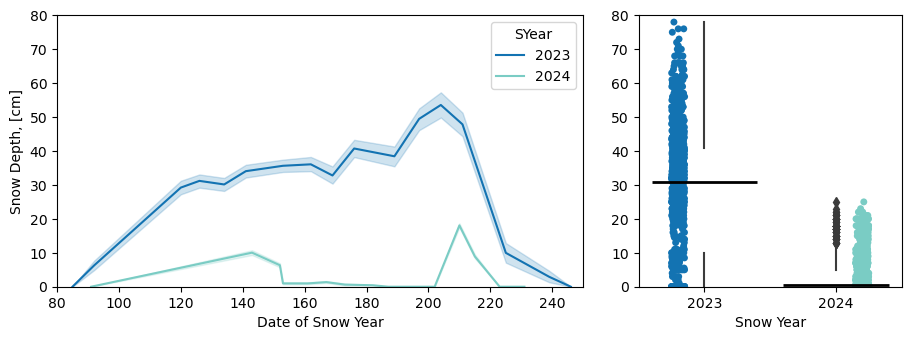

In [15]:
###Plot winter snow timeseries
fig = plt.figure(constrained_layout = True, 
    figsize = (9,6))

gs = GridSpec(2, 3, figure = fig)

ax = fig.add_subplot(gs[0, 0:2])
sns.lineplot(x = allSnow_df.SDOY, y = allSnow_df.depths, hue = allSnow_df.SYear, 
            palette = [pal[4], pal[2]], ax = ax)
ax.set_xlim(80, 250)
ax.set_ylim(0, 80)
ax.set_xlabel('Date of Snow Year')
ax.set_ylabel('Snow Depth, [cm]')

ax2 = fig.add_subplot(gs[0, 2])
sns.boxplot(data = allSnow_df, x = 'SYear', y = 'depths',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = [pal[4], pal[2]],
            ax = ax2, zorder = 1)
sns.stripplot(data = allSnow_df, x = 'SYear', y = 'depths', dodge = True, 
              palette = [pal[4], pal[2]],
              ax = ax2, zorder = 0)
ax2.set_ylim(0, 80)
ax2.set_xlabel('Snow Year')
ax2.set_ylabel(' ')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

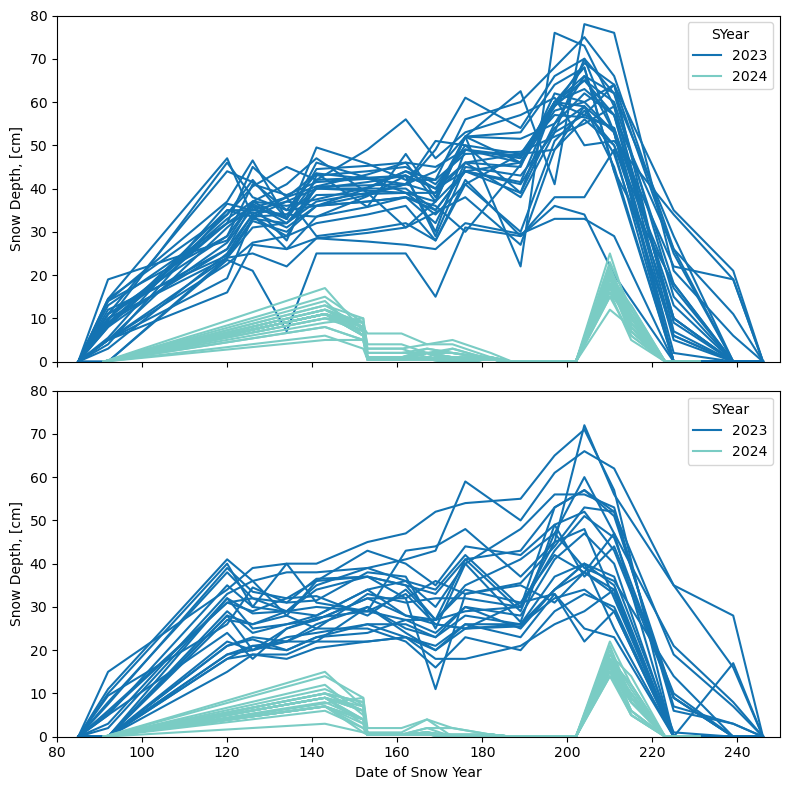

In [16]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (8, 8), 
                               sharex = True, 
                               sharey = True, 
                               layout = 'tight')

sns.lineplot(data = allSnow_df[allSnow_df.watershed == 'S2'], x = 'SDOY', y = 'depths', hue = 'SYear',
            units = 'stakes',
            estimator = None, 
            palette = [pal[4], pal[2]],
            ax = ax1)
ax1.set_xlim(80, 250)
ax1.set_ylim(0, 80)
ax1.set_ylabel('Snow Depth, [cm]')

sns.lineplot(data = allSnow_df[allSnow_df.watershed == 'S6'], x = 'SDOY', y = 'depths', hue = 'SYear',
            units = 'stakes',
            estimator = None, 
            palette = [pal[4], pal[2]],
            ax = ax2)
ax2.set_ylabel('Snow Depth, [cm]')
ax2.set_xlabel('Date of Snow Year')
plt.savefig('./figures/WaterSciCon/snowdepths.pdf')

## LAI Analysis

(0.008631149028106, 2.67733068332974)

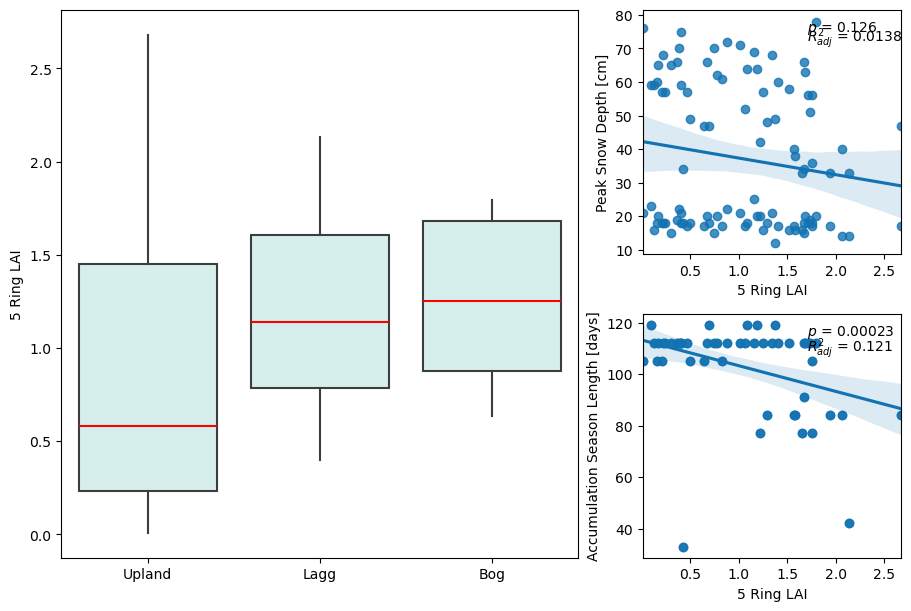

In [17]:
fig = plt.figure(layout = "constrained", figsize = (9, 6))

gs = GridSpec(2, 3, figure = fig)
ax = fig.add_subplot(gs[0:2, 0:2])
sns.boxplot(data = peakData, x = 'zones', y = 'lai5ring',
    notch=False, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": [0.4795847750865052, 0.7984621299500193, 0.7695501730103806, 0.3]},
    medianprops={"color": "red"},
    ax = ax)
ax.set_xlabel(' ')
ax.set_ylabel('5 Ring LAI')

ax2 = fig.add_subplot(gs[0, 2])
sns.regplot(data = peakData, x = 'lai5ring', y = 'maxDepth', color = pal[4])
results = smf.ols('maxDepth ~ lai5ring', data = peakData).fit()
ax2.text(1.7, 75, r'$ p $ = ' + str(round_sig(results.pvalues.lai5ring, 3)))
ax2.text(1.7, 72, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax2.set_xlabel('5 Ring LAI')
ax2.set_ylabel('Peak Snow Depth [cm]')
ax2.set_xlim(min(peakData.lai5ring), max(peakData.lai5ring))

ax3 = fig.add_subplot(gs[1, 2])
sns.regplot(data = meltData, x = 'lai5ring', y = 'accumulate_meas', color = pal[4])
results2 = smf.ols('accumulate_meas ~ lai5ring', data = meltData).fit()
ax3.text(1.7, 115, r'$ p $ = ' + str(round_sig(results2.pvalues.lai5ring, 3)))
ax3.text(1.7, 109, r'$ R_{adj}^2 $ = ' + str(round_sig(results2.rsquared_adj, 3)))

ax3.set_xlabel('5 Ring LAI')
ax3.set_ylabel('Accumulation Season Length [days]')
ax3.set_xlim(min(meltData.lai5ring), max(meltData.lai5ring))

#plt.savefig(fig_savepath + 'laicorplot_boxplot.pdf', bbox_inches = 'tight')



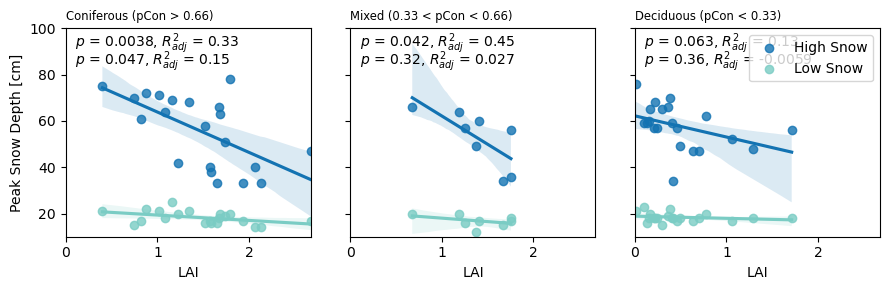

In [18]:
#Prep Data
bins = list(np.linspace(np.nanmin(peakData.pCon), np.nanmax(peakData.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
peakData['Bin'] = pd.cut(peakData['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')

sns.regplot(data = peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)], x = 'lai5ring', y = 'maxDepth', 
            ax = ax1, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)], x = 'lai5ring', y = 'maxDepth', 
            ax = ax1, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseCon_high = smf.ols('maxDepth ~ lai5ring', data = peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2023)]).fit()
resultsDenseCon_low = smf.ols('maxDepth ~ lai5ring', data = peakData[(peakData.Bin == 'Dense Coniferous') & (peakData.SYear == 2024)]).fit()
ax1.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsDenseCon_high.pvalues.lai5ring, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon_high.rsquared_adj, 2)))
ax1.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsDenseCon_low.pvalues.lai5ring, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon_low.rsquared_adj, 2)))
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('LAI')

sns.regplot(data = peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)], x = 'lai5ring', y = 'maxDepth', 
            ax = ax2, 
            color = pal[4])
sns.regplot(data = peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)], x = 'lai5ring', y = 'maxDepth', 
            ax = ax2, 
            color = pal[2])
resultsMixed_high = smf.ols('maxDepth ~ lai5ring', data = peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2023)]).fit()
resultsMixed_low = smf.ols('maxDepth ~ lai5ring', data = peakData[(peakData.Bin == 'Mixed') & (peakData.SYear == 2024)]).fit()
ax2.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsMixed_high.pvalues.lai5ring, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsMixed_high.rsquared_adj, 2)))
ax2.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsMixed_low.pvalues.lai5ring, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsMixed_low.rsquared_adj, 2)))
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('LAI')

sns.regplot(data = peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)], x = 'lai5ring', y = 'maxDepth', 
            ax = ax3, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)], x = 'lai5ring', y = 'maxDepth', 
            ax = ax3, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseDec_high = smf.ols('maxDepth ~ lai5ring', data = peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2023)]).fit()
resultsDenseDec_low = smf.ols('maxDepth ~ lai5ring', data = peakData[(peakData.Bin == 'Dense Deciduous') & (peakData.SYear == 2024)]).fit()
ax3.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsDenseDec_high.pvalues.lai5ring, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec_high.rsquared_adj, 2)))
ax3.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsDenseDec_low.pvalues.lai5ring, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec_low.rsquared_adj, 2)))
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('LAI')

ax1.set_xlim(0, max(peakData.lai5ring))
ax1.set_ylim(10, 100)
ax3.legend(bbox_to_anchor = (1, 1))

#plt.savefig(fig_savepath + 'covertype_lairegression.pdf')

## Canopy Openness

In [21]:
forestInv.columns

Index(['Stake_ID', 'X', 'Zone', 'X..Sky.Area', 'X..Mask.Area', 'X..Cnpy.Open',
       'X..Site.Open', 'LAI.4Ring', 'LAI.5Ring', 'Watershed',
       'OLS.Prediction.Ring.4', 'WLS.Prediction.Ring.4',
       'OLS.Prediction.Ring.5', 'WLS.Prediction.Ring.5', 'Summer.LAI.4Ring',
       'Summer.LAI.5Ring', 'DIST_FT', 'DIST_M', 'DBH_IN', 'DBH_CM',
       'DIST_FT_SD', 'DIST_M_SD', 'DBH_IN_SD', 'DBH_CM_SD', 'n',
       'basalArea_m2', 'BIOMASS', 'Co', 'Dom', 'Int', 'Sup', 'prop_Deciduous',
       'prop_Coniferous', 'WATERSHED', 'OAItree', 'OAI', 'avg_depths',
       'max_depths'],
      dtype='object')

<Axes: xlabel='OLS.Prediction.Ring.5', ylabel='max_depths'>

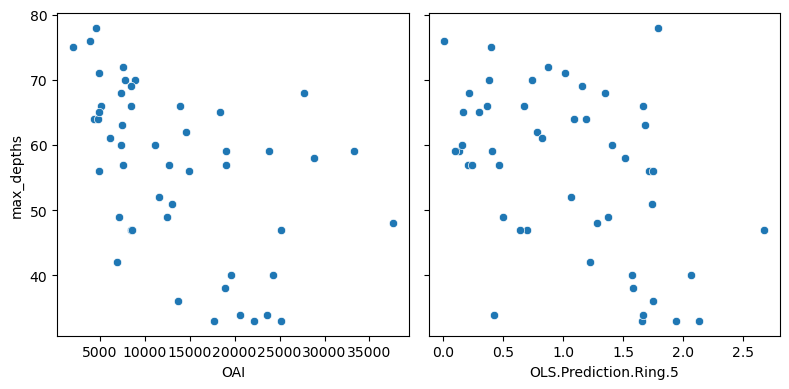

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4), 
                        sharey = True, 
                        layout = 'tight')

sns.scatterplot(data = forestInv, x = 'OAI', y = 'max_depths', 
                ax = axs[0])
sns.scatterplot(data = forestInv, x = 'OLS.Prediction.Ring.5', y = 'max_depths', 
                ax = axs[1])



## Principle Component Analysis

In [ ]:
'''Set PCA Data'''
#Switch this depending on average/maximum snow depth considerations
pca_data = peakData

#remove strings
pca_data_forplot = pca_data.drop(columns = ['stakes', 'zones', 'watershed', 'Bin'])

#remove depths 
pca_data = pca_data_forplot.drop(columns = 'maxDepth')

In [ ]:
'''Principle Component Analysis to Determine Snow Controls'''
#Standardize Data
scaler = StandardScaler()
scaler.fit(pca_data)
pca_data_scaled = scaler.transform(pca_data)
#Convert back to dataframe
pca_scaled = pd.DataFrame(data = pca_data_scaled, 
                            columns = pca_data.columns)


In [ ]:
pca_scaled.head()

In [ ]:
#Run PCA
pca = PCA(n_components = 10) #adjustable
pca.fit_transform(pca_data_scaled)

#Extract variance values
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

In [ ]:
#Scree Plot
PCnumbers = np.arange(pca.n_components_) + 1

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (6, 3), 
                              sharex = True, 
                              tight_layout = True)

ax.plot(PCnumbers, 
         eigenvalues, 
         'o-',
         color = pal[4])
ax.hlines(1, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('Principle Component')

ax2.plot(PCnumbers, 
         np.cumsum(prop_var), 
         'o-', 
         color = pal[4])
ax2.hlines(0.90, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)

ax2.set_ylabel('Proportion of Variance')
ax2.set_xlabel('Principle Component')

ax.set_xlim(0, 11)
#plt.savefig(fig_savepath + 'PCAeigenvalues.pdf', bbox_inches = 'tight')
plt.show()
#Using Kaiser's rule we keep all principle components with eigenvalues above 1 and rerun (here 5)

In [ ]:
#Rerun PCA
pca2 = PCA(n_components = 5) #adjustable
pc = pca2.fit_transform(pca_data_scaled)

pca_snow = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_snow.head()

In [ ]:
'''BiPlot'''
def biplot(ax, data, score, coef, ipca1, ipca2, labels=None, leg=None):
 
    xs = score[:, ipca1]
    ys = score[:, ipca2]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    sns.scatterplot(x = jitter(xs * scalex, 0.1), y = jitter(ys * scaley, 0.1), 
                hue = data.maxDepth, 
                ax = ax,
                palette = 'GnBu',
                legend = leg)
 
    for i in range(n):
        ax.arrow(0, 0, coef[i, ipca1], 
                  coef[i, ipca2], color = 'silver',
                  alpha = 0.5)
        ax.text(coef[i, ipca1]* 1.15, 
                 coef[i, ipca2] * 1.15, 
                 labels[i], 
                 color = 'silver', 
                 ha = 'center', 
                 va = 'center')
 
    ax.set_xlabel("PC{}".format(ipca1 + 1))
    ax.set_ylabel("PC{}".format(ipca2 + 1)) 

    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)

    #plt.title('Biplot of PCA')   

    #plt.show()

 
fig, axs = plt.subplots(2, 2, figsize = (6.5,5), 
                        tight_layout = True, 
                        sharey = True)
for i in range(0, 2):
    for j in range(0, 2):
        if((i == 0) & (j == 0)):
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns), True)
        else:
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns))

axs[0, 0].legend(title = 'Max SD [cm]', bbox_to_anchor = (-0.25, 1))
#plt.savefig(fig_savepath + 'PCAplots.pdf', bbox_inches = 'tight')
plt.show()

### Variable Importance Analysis

In [ ]:
#Sort out PCA coefficients
pca_coefs = pd.DataFrame(data = abs(np.transpose(pca2.components_)), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = pca_data.columns)
pca_coefs.head()

In [ ]:
#Variable Importance Plots
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'Snow Year', 'LAI', 'Mean Dist', 'Mean DBH', 'SD Dist', 'SD DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient')
#plt.savefig(fig_savepath + 'PCAcoef.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
#Version weighted by PCA explained percentage
pca_coefs_weighted = pca_coefs
for i in range(0, 5):
    pca_coefs_weighted.iloc[:, i] = pca_coefs_weighted.iloc[:, i]*prop_var[i]

pca_coefs_weighted.head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs_weighted.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'Snow Year', 'LAI', 'Mean Dist', 'Mean DBH', 'SD Dist', 'SD DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient, weighted')
#plt.savefig(fig_savepath + 'PCAcoef-weighted.pdf', bbox_inches = 'tight')
plt.show()

## Random Forest Variable Importance

In [ ]:
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

In [ ]:
#Variable intercorrelation
pvals = calculate_pvalues(pca_data) 
sigvals = np.where(pvals < 0.05, pvals, np.nan)

sns.heatmap(pca_data.corr(),
                xticklabels=pca_data.columns,
                yticklabels=pca_data.columns, 
            cmap = 'vlag', 
            mask = sigvals, 
            center = 0, 
            vmin = -1, vmax = 1)

### Variable Importance for Peak Snow Depth

In [ ]:
#Split data
X_train_2023, X_test_2023, y_train_2023, y_test_2023 = train_test_split(pca_data[pca_data.SYear == 2023],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2023].maxDepth,
                                                                        test_size = 0.5, random_state = 48492)
X_train_2024, X_test_2024, y_train_2024, y_test_2024 = train_test_split(pca_data[pca_data.SYear == 2024],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2024].maxDepth,
                                                                        test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf2023 = RandomForestRegressor(n_estimators = 100)
rf2023.fit(X_train_2023, y_train_2023)
rf2024 = RandomForestRegressor(n_estimators = 100)
rf2024.fit(X_train_2024, y_train_2024)

In [ ]:
#Model assessment
preds2023 = rf2023.predict(X_test_2023)
preds2024 = rf2024.predict(X_test_2024)

#Score
print('2023 High Snow Model\n')
print(rf2023.score(X_train_2023, y_train_2023))
print(rf2023.score(X_test_2023, y_test_2023))

print('\n2024 Low Snow Model\n')
print(rf2024.score(X_train_2024, y_train_2024))
print(rf2024.score(X_test_2024, y_test_2024))

#Overfitting problem

In [ ]:
#Sort and plot feature importance
sorted_idx2023 = rf2023.feature_importances_.argsort()
sorted_idx2024 = rf2024.feature_importances_.argsort()

fig,[[ax, ax3],[ax2, ax4]] = plt.subplots(2, 2, figsize = (10, 5), 
                              sharex = True, 
                              tight_layout = True)

#2023
#Without permutation
ax.barh(pca_data.columns[sorted_idx2023], rf2023.feature_importances_[sorted_idx2023], 
        color = pal[4])
#ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance2023 = permutation_importance(rf2023, X_test_2023, y_test_2023)

sorted_idx2023 = perm_importance2023.importances_mean.argsort()
ax2.barh(pca_data[pca_data.SYear == 2023].columns[sorted_idx2023], perm_importance2023.importances_mean[sorted_idx2023], 
         color = pal[4])
#ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])

#2024
#Without permutation
ax3.barh(pca_data.columns[sorted_idx2024], rf2024.feature_importances_[sorted_idx2024], 
        color = pal[4])
#ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance2024 = permutation_importance(rf2024, X_test_2024, y_test_2024)

sorted_idx2024 = perm_importance2024.importances_mean.argsort()
ax4.barh(pca_data[pca_data.SYear == 2024].columns[sorted_idx2024], perm_importance2024.importances_mean[sorted_idx2024], 
         color = pal[4])
#ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])


ax2.set_xlabel("Random Forest Feature Importance")
ax4.set_xlabel("Random Forest Feature Importance")


#plt.savefig(fig_savepath + 'randomForest-importance.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
#SHAP values
explainer2023 = shap.TreeExplainer(rf2023)
shap_values2023 = explainer2023.shap_values(X_test_2023)
explainer2024 = shap.TreeExplainer(rf2024)
shap_values2024 = explainer2024.shap_values(X_test_2024)


fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values2023, X_test_2023,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
#ax.set_yticklabels(['# Co', 'Mean DBH', 'pCon', r'/sigma DBH', '# Trees', 'LAI', '# Dom', r'\sigma Distance', 'Northing', '# Sup', 'Mean Distance', 'Easting', 'Slope', '# Int', 'Aspect', 'Basal Area', 'Year'])
ax.set_yticklabels(['Year', 'Basal Area', 'Aspect', '# Int', 'Slope', 'Easting', 'Mean Distance', '# Sup', 'Northing', r'$\sigma$ Distance', '# Dom', 'LAI', '# Trees', r'$\sigma$ DBH', 'pCon', 'Mean DBH', '# Co'])
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-highsnow.pdf', bbox_inches = 'tight')
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-highsnow.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values2024, X_test_2024,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
#ax.set_yticklabels([r'$\sigma$ Distance', '# Co', '# Trees', 'pCon', '# Sup', 'Mean DBH', 'Slope', r'$\sigma$ DBH', 'Mean Distance', 'Aspect', 'Basal Area', 'LAI', '# Dom', 'Easting', 'Northing', '# Int', 'Year'])
ax.set_yticklabels(['Year', '# Int', 'Northing', 'Easting', '# Dom', 'LAI', 'Basal Area', 'Aspect', 'Mean Distance', r'$\sigma$ DBH', 'Slope', 'Mean DBH', '# Sup', 'pCon', '# Trees', '# Co', r'$\sigma$ Distance' ])
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-lowsnow.pdf', bbox_inches = 'tight')
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-lowsnow.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

### Variable Importance Using Reduced Dimensions

In [ ]:
pca_data_reduced = pca_data.drop(columns = ['northing', 'easting', 'SYear', 'nTrees', 'basalArea_m2', 'nInt', 'nSup', 'nDom'])

In [ ]:
#Split data
X_train_reduced_2023, X_test_reduced_2023, y_train_reduced_2023, y_test_reduced_2023 = train_test_split(pca_data_reduced[pca_data.SYear == 2023],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2023].maxDepth,
                                                                        test_size = 0.2, random_state = 48492)
X_train_reduced_2024, X_test_reduced_2024, y_train_reduced_2024, y_test_reduced_2024 = train_test_split(pca_data_reduced[pca_data.SYear == 2024],
                                                                        pca_data_forplot[pca_data_forplot.SYear == 2024].maxDepth,
                                                                        test_size = 0.2, random_state = 48492)

#Fit random forest regression with 100 trees
rf2023_red = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf2023_red.fit(X_train_reduced_2023, y_train_reduced_2023)
rf2024_red = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf2024_red.fit(X_train_reduced_2024, y_train_reduced_2024)

In [ ]:
#Model assessment
preds2023_red = rf2023_red.predict(X_test_reduced_2023)
preds2024_red = rf2024_red.predict(X_test_reduced_2024)

y2023 = y_test_reduced_2023
print('2023 Snow Year ')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y2023, preds2023_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y2023, preds2023_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y2023, preds2023_red)))
mape = np.mean(np.abs((y2023 - preds2023_red) / np.abs(y2023)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf2023_red.score(X_train_reduced_2023, y_train_reduced_2023))
print('Testing Score:', rf2023_red.score(X_test_reduced_2023, y_test_reduced_2023))
print('Accuracy:', round(100*(1 - mape), 2))

y2024 = y_test_reduced_2024
print('\n2024 Snow Year ')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y2024, preds2024_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y2024, preds2024_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y2024, preds2024_red)))
mape = np.mean(np.abs((y2024 - preds2024_red) / np.abs(y2024)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf2024_red.score(X_train_reduced_2024, y_train_reduced_2024))
print('Testing Score:', rf2024_red.score(X_test_reduced_2024, y_test_reduced_2024))
print('Accuracy:', round(100*(1 - mape), 2))

#### ML Model Tuning

In [ ]:
#Test different model hyperparameters
max_depths = np.linspace(1, 32, 32, endpoint=True, dtype = 'int')

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for max_depth in max_depths:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 100, max_depth = max_depth, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 100, max_depth = max_depth, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = max_depths, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = max_depths, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = max_depths, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = max_depths, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
#Test different model hyperparameters
n_trees = np.linspace(10, 1000, 30, endpoint=True, dtype = 'int')

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for tree in n_trees:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = tree, max_depth = 5, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = tree, max_depth = 5, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = n_trees, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = n_trees, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = n_trees, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = n_trees, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('# Trees')
plt.show()

In [ ]:
#Test different model hyperparameters
min_samples_leafs = np.linspace(0.01, 0.99, 10, endpoint=True)

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for leaf in min_samples_leafs:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = leaf, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = leaf, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = min_samples_leafs, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = min_samples_leafs, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = min_samples_leafs, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = min_samples_leafs, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Min Samples Leaf')
plt.show()

In [ ]:
#Test different model hyperparameters
max_features = list(range(1,X_train_reduced_2023.shape[1]))

train_results2023 = []
test_results2023 = []
train_results2024 = []
test_results2024 = []

for feature in max_features:
   #Fit models
   rf2023 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = 0.1, max_features = feature, n_jobs = -1)
   rf2023.fit(X_train_reduced_2023, y_train_reduced_2023)
   rf2024 = RandomForestRegressor(n_estimators = 10, max_depth = 5, min_samples_leaf = 0.1, max_features = feature, n_jobs = -1)
   rf2024.fit(X_train_reduced_2024, y_train_reduced_2024)

   #Predict data
   train_pred2023 = rf2023.predict(X_train_reduced_2023)
   y_pred2023 = rf2023.predict(X_test_reduced_2023)
   train_pred2024 = rf2024.predict(X_train_reduced_2024)
   y_pred2024 = rf2024.predict(X_test_reduced_2024)

   #Calculate MSE
   train_results2023.append(metrics.mean_squared_error(y_train_reduced_2023, train_pred2023))
   test_results2023.append(metrics.mean_squared_error(y_test_reduced_2023, y_pred2023))
   train_results2024.append(metrics.mean_squared_error(y_train_reduced_2024, train_pred2024))
   test_results2024.append(metrics.mean_squared_error(y_test_reduced_2024, y_pred2024))


sns.lineplot(x = max_features, y = train_results2023, color = 'blue', linestyle = '--', label = 'Train MSE, 2023')
sns.lineplot(x = max_features, y = test_results2023, color = 'blue', label = 'Test MSE, 2023')
sns.lineplot(x = max_features, y = train_results2024, color = 'red', linestyle = '--', label = 'Train MSE, 2024')
sns.lineplot(x = max_features, y = test_results2024, color = 'red', label = 'Test MSE, 2024')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Max Features')
plt.show()

#### All data - Snow Year Dummy Variable

In [ ]:
pca_data_reduced_all = pca_data.drop(columns = ['northing', 'easting', 'nTrees', 'basalArea_m2', 'nInt', 'nSup', 'nDom'])

In [ ]:
#Split data
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(pca_data_reduced_all,
                                                                        pca_data_forplot.maxDepth,
                                                                        test_size = 0.2, random_state = 48492)

In [ ]:
#Test different model hyperparameters
params = np.linspace(1, 32, 32, endpoint=True, dtype = 'int') #tree depths
#params = np.linspace(10, 1000, 30, endpoint=True, dtype = 'int') #n trees
#params = np.linspace(0.01, 0.99, 10, endpoint=True) #min leafs
#params  = list(range(1,X_train_reduced.shape[1])) # max features

train_results = []
test_results = []

for param in params:
   #Fit models
   rf = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_leaf = 0.1, max_features = 9, n_jobs = -1)
   rf.fit(X_train_reduced, y_train_reduced)

   #Predict data
   train_pred = rf.predict(X_train_reduced)
   y_pred = rf.predict(X_test_reduced)

   #Calculate MSE
   train_results.append(metrics.mean_squared_error(y_train_reduced, train_pred))
   test_results.append(metrics.mean_squared_error(y_test_reduced, y_pred))


sns.lineplot(x = params, y = train_results, color = 'blue', linestyle = '--', label = 'Train MSE')
sns.lineplot(x = params, y = test_results, color = 'blue', label = 'Test MSE')
plt.ylabel('Mean Square Error (MSE)')
plt.xlabel('Parameter Value')
plt.show()

In [ ]:
#Fit random forest regression with tuned hyperparameters
rf_red = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_leaf = 0.1, max_features = 9)
rf_red.fit(X_train_reduced, y_train_reduced)

In [ ]:
preds_red = rf_red.predict(X_test_reduced)

y = y_test_reduced
print('All Snow Years')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y, preds_red))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y, preds_red))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y, preds_red)))
mape = np.mean(np.abs((y - preds_red) / np.abs(y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf_red.score(X_train_reduced, y_train_reduced))
print('Testing Score:', rf_red.score(X_test_reduced, y_test_reduced))
print('Accuracy:', round(100*(1 - mape), 2))

In [ ]:
#SHAP values
explainer_red = shap.TreeExplainer(rf_red)
shap_values_red = explainer_red.shap_values(X_test_reduced)


fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values_red, X_test_reduced,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
#ax.set_yticklabels(['# Co', 'Mean DBH', 'pCon', r'/sigma DBH', '# Trees', 'LAI', '# Dom', r'\sigma Distance', 'Northing', '# Sup', 'Mean Distance', 'Easting', 'Slope', '# Int', 'Aspect', 'Basal Area', 'Year'])
#ax.set_yticklabels(['Year', 'Basal Area', 'Aspect', '# Int', 'Slope', 'Easting', 'Mean Distance', '# Sup', 'Northing', r'$\sigma$ Distance', '# Dom', 'LAI', '# Trees', r'$\sigma$ DBH', 'pCon', 'Mean DBH', '# Co'])
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-allsnow.pdf', bbox_inches = 'tight')
plt.savefig('./figures/WaterSciCon/randomForest-SHAP-allsnow.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


In [ ]:
#Pull out row shap data for each snow year
s2023_ids = np.where(X_test_reduced.SYear == 2023)
sv2023 = shap_values_red[s2023_ids]

s2024_ids = np.where(X_test_reduced.SYear == 2024)
sv2024 = shap_values_red[s2024_ids]

In [ ]:
fig, ax = plt.subplots(1, 1)
shap.summary_plot(sv2023, X_test_reduced[X_test_reduced.SYear == 2023],
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(sv2024, X_test_reduced[X_test_reduced.SYear == 2024],
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

In [ ]:
#Also try dividing by cover type
conif_ids = np.where(X_test_reduced.pCon > bins[2])
svConif = shap_values_red[conif_ids]

mixed_ids = np.where((X_test_reduced.pCon > bins[1]) & (X_test_reduced.pCon < bins[2]))
svMixed = shap_values_red[mixed_ids]


decid_ids = np.where((X_test_reduced.pCon < bins[1]))
svDecid = shap_values_red[decid_ids]

In [ ]:
fig, ax = plt.subplots(1, 1)
shap.summary_plot(svConif, X_test_reduced[X_test_reduced.pCon > bins[2]],
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(svMixed, X_test_reduced[(X_test_reduced.pCon > bins[1]) & (X_test_reduced.pCon < bins[2])],
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

fig, ax = plt.subplots(1, 1)
shap.summary_plot(svDecid, X_test_reduced[(X_test_reduced.pCon < bins[1])],
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Attribute Value', 
                use_log_scale = True, 
                show = False)
plt.show()

### Repeat Analysis for Snow Melt Rates

In [ ]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(pca_data_reduced_all, meltData.melt_meas, test_size = 0.2, random_state = 48492)

#Fit random forest regression with 100 trees
rf_melt = RandomForestRegressor(n_estimators = 100, max_depth = 4, max_features = 9)
rf_melt.fit(X_train, y_train)

In [ ]:
preds_melt = rf_melt.predict(X_test)

y = y_test
print('All Snow Years')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y, preds_melt))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y, preds_melt))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y, preds_melt)))
mape = np.mean(np.abs((y - preds_melt) / np.abs(y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Training Score:', rf_melt.score(X_train, y_train))
print('Testing Score:', rf_melt.score(X_test, y_test))
print('Accuracy:', round(100*(1 - mape), 2))

In [ ]:
#SHAP values
explainer = shap.TreeExplainer(rf_melt)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Melt Rate', 
                use_log_scale = True, 
                show = False)

#plt.savefig(fig_savepath + 'randomForest-SHAP-melt.pdf', bbox_inches = 'tight')